In [92]:
import numpy as np 
import pandas as pd 
import torch 
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision import datasets
import torch.optim as optim 

from datetime import datetime
import pickle as pkl

In [93]:
num_workers  = 4
batch_size = 128
transform = transforms.ToTensor()

train_data = datasets.MNIST(root='data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)

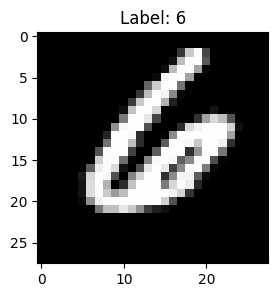

In [94]:
rand_index = np.random.randint(0, len(train_data),1)[0]
images = train_data[rand_index][0]
labels = train_data[rand_index][1]
images = images.numpy()
img = np.squeeze(images[0])
fig = plt.figure(figsize = (3,3))
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
plt.title(f'Label: {labels}')
plt.show()

GAN COMPRISES OF TWO ADVERSARIAL NETWORKS, DISCRIMINATOR AND GENERATOR.

In [95]:
# class Discriminator(nn.Module):
#     def __init__(self, input_size: int, hidden_dim: int):
#         super(Discriminator, self).__init__()
#         self.image_size = int(input_size ** 0.5)
#         self.hidden_dim = hidden_dim

#         self.dconv1 = nn.Conv2d(in_channels=1, out_channels=hidden_dim, kernel_size=4, stride=2, padding=1)
#         self.dconv2 = nn.Conv2d(in_channels=hidden_dim, out_channels=hidden_dim*2, kernel_size=4, stride=2, padding=1)
#         self.fc = nn.Linear(hidden_dim*2*7*7, 1)

#     def forward(self, x: torch.Tensor) -> torch.Tensor:
#         x = x.view(-1, 1, self.image_size, self.image_size)  
#         x = F.leaky_relu(self.dconv1(x), negative_slope=0.2)
#         x = F.leaky_relu(self.dconv2(x), negative_slope=0.2)
#         x = x.view(-1, self.hidden_dim*2*7*7)
#         x = self.fc(x)
#         return x

class Discriminator(nn.Module):
    def __init__(self, input_size: int, hidden_dim: int):
        super(Discriminator, self).__init__()
        # define hidden linear layers
        self.fc1 = nn.Linear(input_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.fc3 = nn.Linear(hidden_dim // 2, hidden_dim // 4)
        
        # define the final layer
        self.fc4 = nn.Linear(hidden_dim // 4, 1)        
        
        # define the dropout
        self.dropout = nn.Dropout(0.3)
        
        # define the activation
        self.activation = nn.LeakyReLU(0.2)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # flatten image
        x = x.view(-1, 28*28)
        
        x = self.fc1(x)
        x = self.activation(x)
        x = self.dropout(x)

        x = self.fc2(x)
        x = self.activation(x)
        x = self.dropout(x)

        x = self.fc3(x)
        x = self.activation(x)
        x = self.dropout(x)
        
        # we are using BCE with logits loss so the last activation is not required
        x = self.fc4(x)
        return x

In [96]:

class Generator(nn.Module):
    def __init__(self, latent_dim:int, hidden_dim:int, output_size:int):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(latent_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim*2)
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim*4)
        self.fc4 = nn.Linear(hidden_dim*4, output_size)
        self.activation = nn.LeakyReLU(0.2)
        self.final_activation = nn.Tanh()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        x = self.activation(x)
        x = self.fc3(x)
        x = self.activation(x)
        x = self.fc4(x)
        x = self.final_activation(x)
        return x

In [97]:

input_size = 784
d_hidden_size = 128
z_size = 100
g_output_size = 784
g_hidden_size = 32

In [98]:
D = Discriminator(input_size, d_hidden_size)
G = Generator(z_size, g_hidden_size, g_output_size)
print(D)
print()
print(G)

Discriminator(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (activation): LeakyReLU(negative_slope=0.2)
)

Generator(
  (fc1): Linear(in_features=100, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=784, bias=True)
  (activation): LeakyReLU(negative_slope=0.2)
  (final_activation): Tanh()
)


In [99]:
def real_loss(D_out, smooth=False):
    batch_size = D_out.size(0)
    labels = torch.ones(batch_size, 1) * 0.9 if smooth else torch.ones(batch_size, 1)
    labels = labels.to(D_out.device)
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out, labels)
    return loss

def fake_loss(D_out):
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size, 1)
    labels = labels.to(D_out.device)
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out, labels)
    return loss

OPTIMIZERS:
Two seperate optimizers for Discriminator and Generator

In [100]:
lr = 0.0002
d_optimizer = optim.Adam(D.parameters(),lr)
g_optimizer = optim.Adam(G.parameters(),lr)


In [101]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(14,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')
    plt.show()

2024-06-11 11:08:18 | Epoch [1/10] | Batch 0/469 | d_loss: 1.4352 | g_loss: 0.7905
2024-06-11 11:08:20 | Epoch [1/10] | Batch 100/469 | d_loss: 1.2847 | g_loss: 0.5525
2024-06-11 11:08:21 | Epoch [1/10] | Batch 200/469 | d_loss: 0.3714 | g_loss: 1.7373
2024-06-11 11:08:23 | Epoch [1/10] | Batch 300/469 | d_loss: 0.2137 | g_loss: 2.4918
2024-06-11 11:08:24 | Epoch [1/10] | Batch 400/469 | d_loss: 0.4092 | g_loss: 1.5899


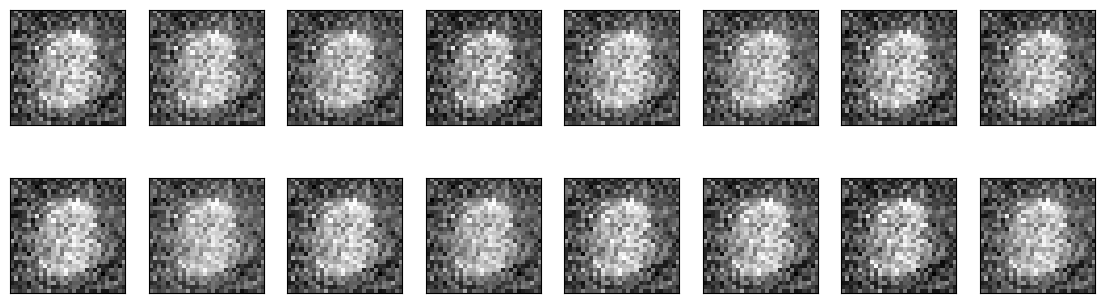

2024-06-11 11:08:28 | Epoch [2/10] | Batch 0/469 | d_loss: 0.4652 | g_loss: 1.6602
2024-06-11 11:08:29 | Epoch [2/10] | Batch 100/469 | d_loss: 0.3876 | g_loss: 2.1252
2024-06-11 11:08:30 | Epoch [2/10] | Batch 200/469 | d_loss: 0.3951 | g_loss: 2.9433
2024-06-11 11:08:31 | Epoch [2/10] | Batch 300/469 | d_loss: 0.4401 | g_loss: 2.5825
2024-06-11 11:08:33 | Epoch [2/10] | Batch 400/469 | d_loss: 0.3786 | g_loss: 2.9547


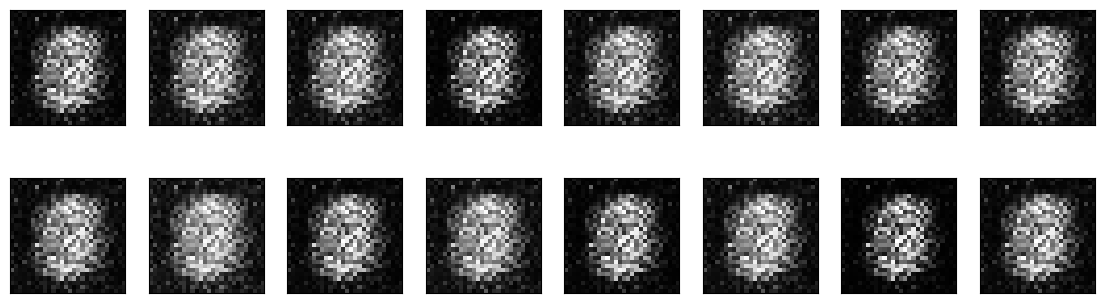

2024-06-11 11:08:37 | Epoch [3/10] | Batch 0/469 | d_loss: 0.6645 | g_loss: 1.8047
2024-06-11 11:08:38 | Epoch [3/10] | Batch 100/469 | d_loss: 0.5907 | g_loss: 2.5634
2024-06-11 11:08:39 | Epoch [3/10] | Batch 200/469 | d_loss: 0.3823 | g_loss: 2.7223
2024-06-11 11:08:40 | Epoch [3/10] | Batch 300/469 | d_loss: 0.1821 | g_loss: 3.8407
2024-06-11 11:08:42 | Epoch [3/10] | Batch 400/469 | d_loss: 0.3458 | g_loss: 2.4584


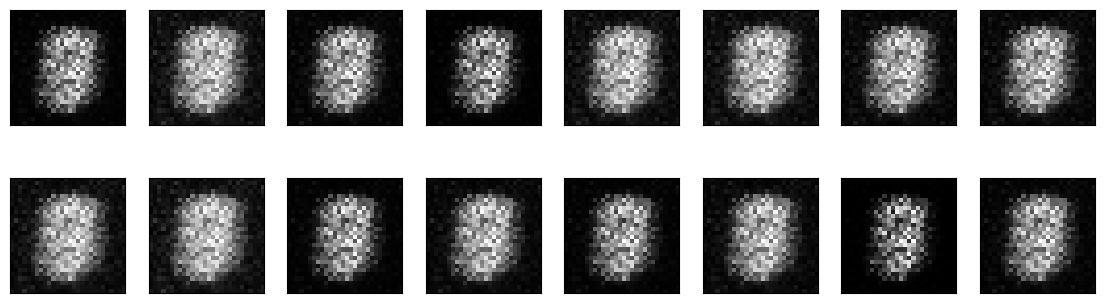

2024-06-11 11:08:45 | Epoch [4/10] | Batch 0/469 | d_loss: 0.4452 | g_loss: 2.3709
2024-06-11 11:08:47 | Epoch [4/10] | Batch 100/469 | d_loss: 0.5417 | g_loss: 2.4885
2024-06-11 11:08:48 | Epoch [4/10] | Batch 200/469 | d_loss: 0.1899 | g_loss: 3.5501
2024-06-11 11:08:49 | Epoch [4/10] | Batch 300/469 | d_loss: 0.2111 | g_loss: 3.5436
2024-06-11 11:08:50 | Epoch [4/10] | Batch 400/469 | d_loss: 0.2296 | g_loss: 3.5460


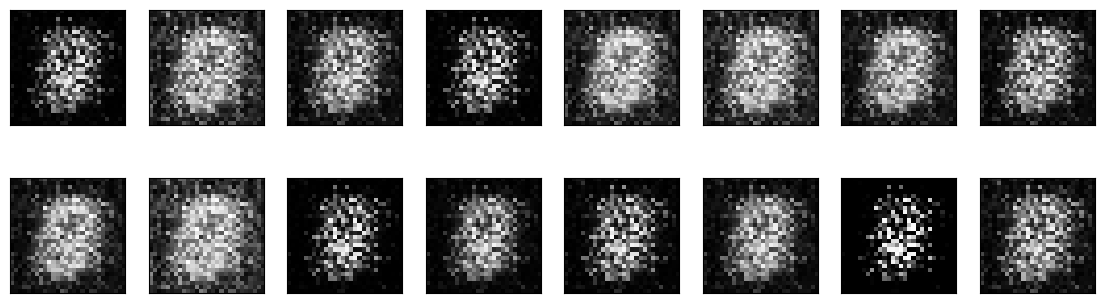

2024-06-11 11:08:54 | Epoch [5/10] | Batch 0/469 | d_loss: 0.1361 | g_loss: 4.3573
2024-06-11 11:08:55 | Epoch [5/10] | Batch 100/469 | d_loss: 0.3810 | g_loss: 3.9614
2024-06-11 11:08:56 | Epoch [5/10] | Batch 200/469 | d_loss: 0.2458 | g_loss: 4.2241
2024-06-11 11:08:57 | Epoch [5/10] | Batch 300/469 | d_loss: 0.3744 | g_loss: 3.7165
2024-06-11 11:08:58 | Epoch [5/10] | Batch 400/469 | d_loss: 0.1736 | g_loss: 3.5058


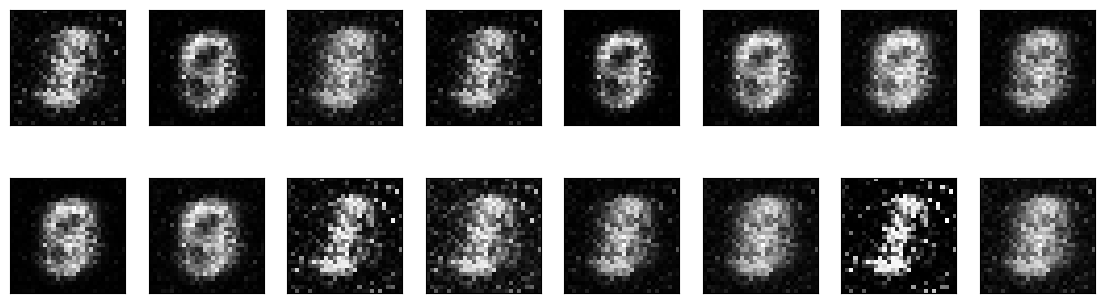

2024-06-11 11:09:02 | Epoch [6/10] | Batch 0/469 | d_loss: 0.2800 | g_loss: 3.2278
2024-06-11 11:09:03 | Epoch [6/10] | Batch 100/469 | d_loss: 0.2682 | g_loss: 3.4459
2024-06-11 11:09:04 | Epoch [6/10] | Batch 200/469 | d_loss: 0.1517 | g_loss: 2.9469
2024-06-11 11:09:06 | Epoch [6/10] | Batch 300/469 | d_loss: 0.2677 | g_loss: 3.8483
2024-06-11 11:09:07 | Epoch [6/10] | Batch 400/469 | d_loss: 0.2467 | g_loss: 4.1999


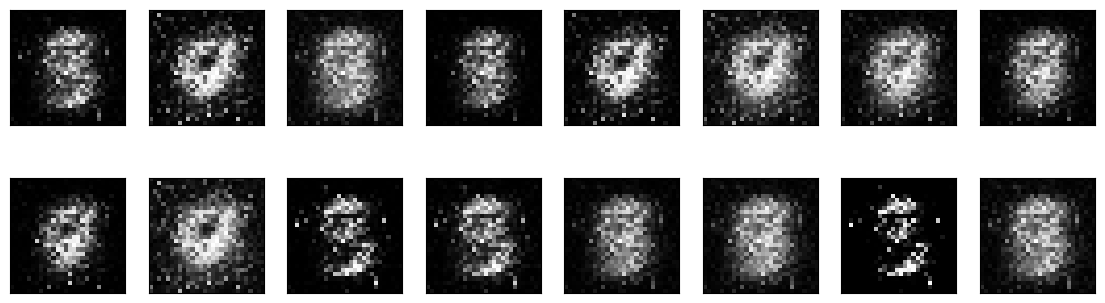

2024-06-11 11:09:11 | Epoch [7/10] | Batch 0/469 | d_loss: 0.2013 | g_loss: 3.5639
2024-06-11 11:09:12 | Epoch [7/10] | Batch 100/469 | d_loss: 0.2212 | g_loss: 3.6945
2024-06-11 11:09:13 | Epoch [7/10] | Batch 200/469 | d_loss: 0.2647 | g_loss: 2.9658
2024-06-11 11:09:14 | Epoch [7/10] | Batch 300/469 | d_loss: 0.3578 | g_loss: 3.3625
2024-06-11 11:09:15 | Epoch [7/10] | Batch 400/469 | d_loss: 0.5408 | g_loss: 3.5565


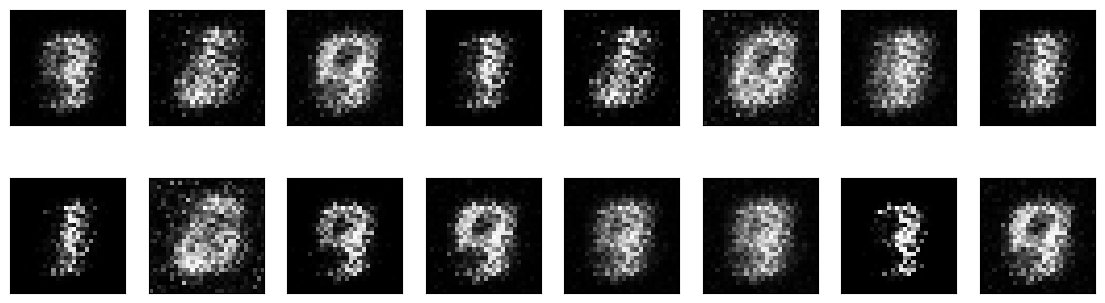

2024-06-11 11:09:19 | Epoch [8/10] | Batch 0/469 | d_loss: 0.4523 | g_loss: 3.0373
2024-06-11 11:09:20 | Epoch [8/10] | Batch 100/469 | d_loss: 0.2626 | g_loss: 3.0537
2024-06-11 11:09:21 | Epoch [8/10] | Batch 200/469 | d_loss: 0.2006 | g_loss: 4.1342
2024-06-11 11:09:23 | Epoch [8/10] | Batch 300/469 | d_loss: 0.2378 | g_loss: 3.8668
2024-06-11 11:09:24 | Epoch [8/10] | Batch 400/469 | d_loss: 0.2254 | g_loss: 3.5584


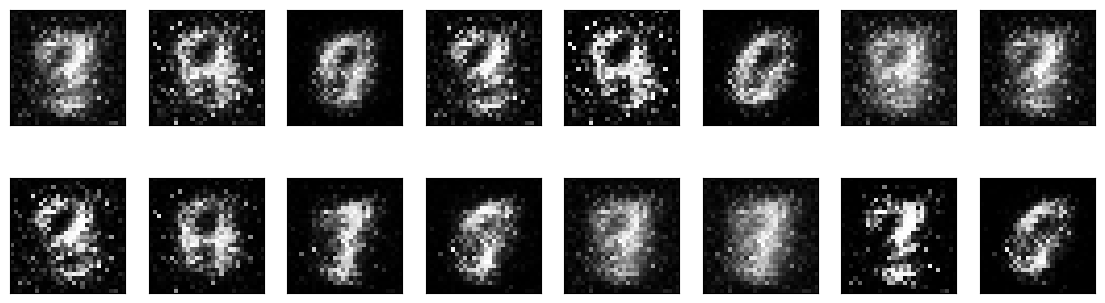

2024-06-11 11:09:27 | Epoch [9/10] | Batch 0/469 | d_loss: 0.2865 | g_loss: 4.2571
2024-06-11 11:09:29 | Epoch [9/10] | Batch 100/469 | d_loss: 0.3455 | g_loss: 2.6401
2024-06-11 11:09:30 | Epoch [9/10] | Batch 200/469 | d_loss: 0.3871 | g_loss: 3.3838
2024-06-11 11:09:31 | Epoch [9/10] | Batch 300/469 | d_loss: 0.3532 | g_loss: 3.2059
2024-06-11 11:09:32 | Epoch [9/10] | Batch 400/469 | d_loss: 0.3599 | g_loss: 2.7727


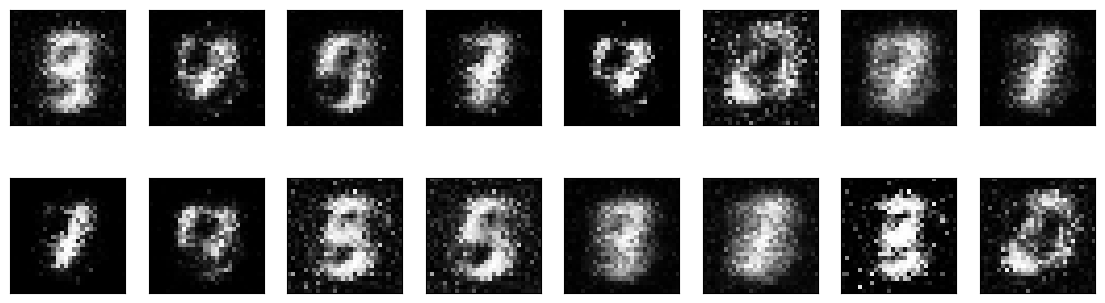

2024-06-11 11:09:36 | Epoch [10/10] | Batch 0/469 | d_loss: 0.3113 | g_loss: 3.2248
2024-06-11 11:09:37 | Epoch [10/10] | Batch 100/469 | d_loss: 0.2710 | g_loss: 2.6329
2024-06-11 11:09:38 | Epoch [10/10] | Batch 200/469 | d_loss: 0.2941 | g_loss: 2.8022
2024-06-11 11:09:39 | Epoch [10/10] | Batch 300/469 | d_loss: 0.2950 | g_loss: 2.9533
2024-06-11 11:09:41 | Epoch [10/10] | Batch 400/469 | d_loss: 0.3117 | g_loss: 3.1472


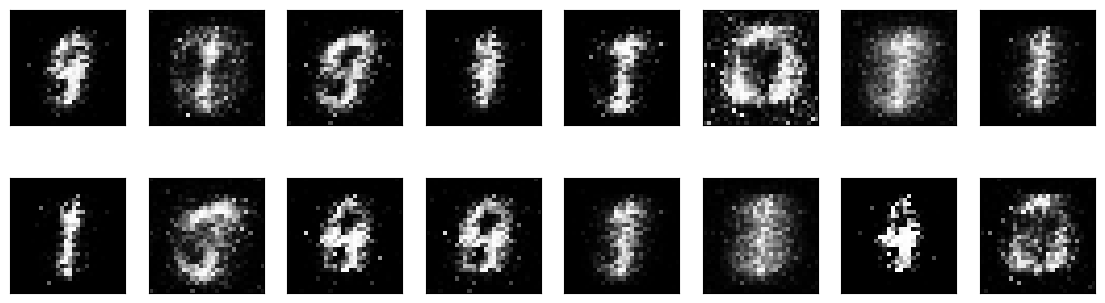

In [102]:
num_epochs = 10
samples = []
losses = []

print_every = 100

sample_size = 16
z_size = 100  # Define the size of the latent vector z
fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
fixed_z = torch.from_numpy(fixed_z).float()

D.train()
G.train()

for epoch in range(num_epochs):
    for batch_i, (real_images, _) in enumerate(train_loader):
        batch_size = real_images.size(0)
        real_images = real_images * 2 - 1  # Rescale images from [0, 1) to [-1, 1)

        # Correct Shape
        real_images = real_images.view(batch_size, 1, 28, 28)  

        # Training Discriminator
        d_optimizer.zero_grad()

        # Real images
        real_outputs = D(real_images)
        d_real_loss = real_loss(real_outputs)

        # Fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        fake_images = G(z)
        fake_outputs = D(fake_images)
        d_fake_loss = fake_loss(fake_outputs)

        # Combine losses
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()

        # Training Generator
        g_optimizer.zero_grad()

        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        fake_images = G(z)
        fake_outputs = D(fake_images)
        g_loss = real_loss(fake_outputs)  

        g_loss.backward()
        g_optimizer.step()

        if batch_i % print_every == 0:
            time = str(datetime.now()).split('.')[0]
            print(f'{time} | Epoch [{epoch+1}/{num_epochs}] | Batch {batch_i}/{len(train_loader)} | d_loss: {d_loss.item():.4f} | g_loss: {g_loss.item():.4f}')
            losses.append((d_loss.item(), g_loss.item()))

    G.eval()  
    samples_z = G(fixed_z)
    samples.append(samples_z)
    view_samples(-1, samples)  
    G.train()  

# Save the samples for viewing later
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)


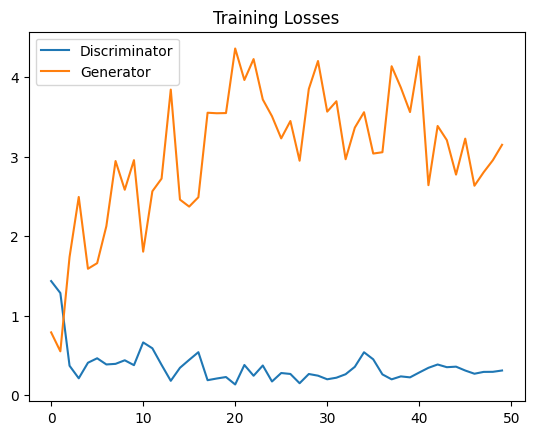

In [103]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

In [104]:
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

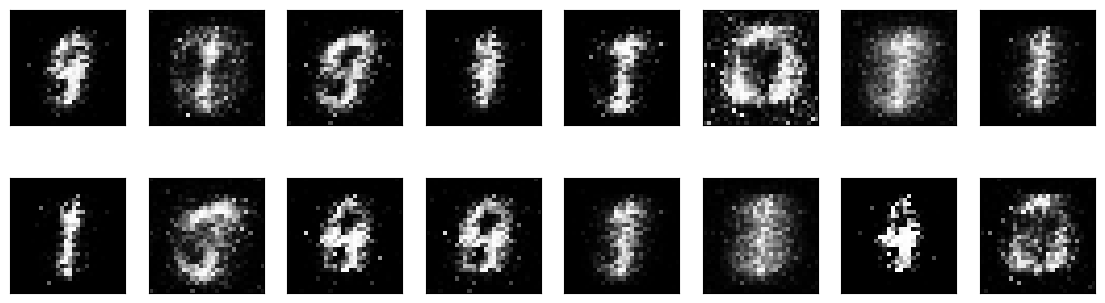

In [105]:
view_samples(-1, samples)

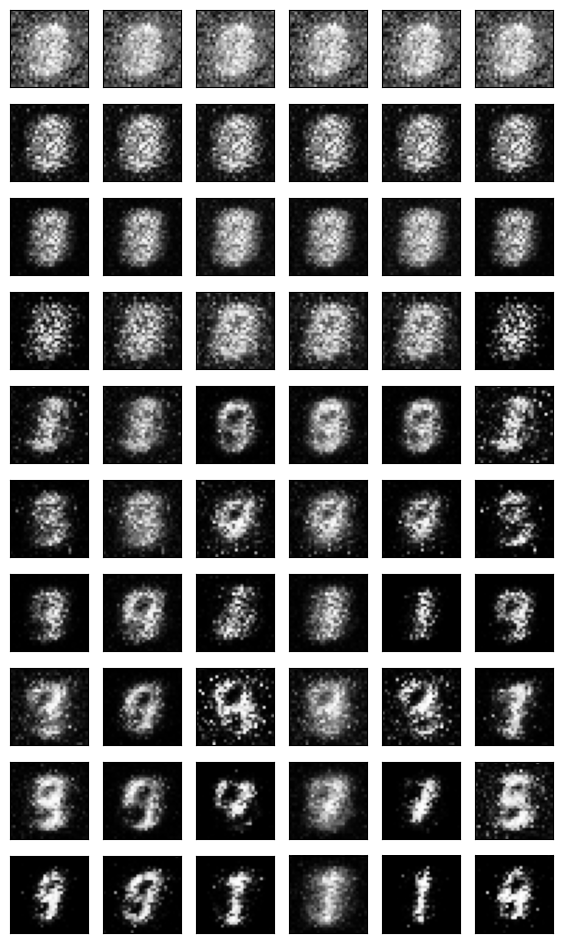

In [106]:
rows = 10 # split epochs into 10, so 100/10 = every 10 epochs
cols = 6
fig, axes = plt.subplots(figsize=(7,12), nrows=rows, ncols=cols, sharex=True, sharey=True)

for sample, ax_row in zip(samples[::int(len(samples)/rows)], axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        img = img.detach()
        ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

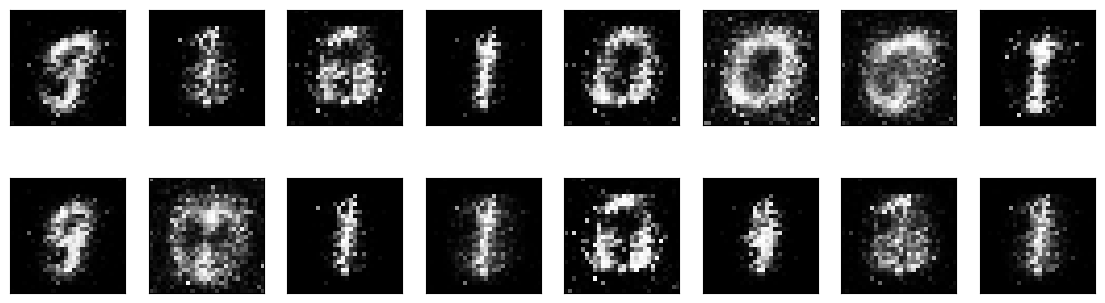

In [107]:
# randomly generated, new latent vectors
sample_size = 16
rand_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
rand_z = torch.from_numpy(rand_z).float()

G.eval() 
rand_images = G(rand_z)
view_samples(0, [rand_images])